In [1]:
# 02 Strategy Analysis — Spot, Options, and Signal Quality
# ===========================================================
# Strategies: Spot (baseline), ATM call/put, 25-delta risk reversal
# New: signal quality ranking to improve Sharpe with selective sizing

import sys, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.dpi': 120, 'font.size': 10})

project_root = Path.cwd().parent if Path.cwd().name == 'signals' else Path.cwd()
sys.path.insert(0, str(project_root / 'signals' / 'scripts'))
sys.path.insert(0, str(project_root / 'src'))

from fx_skew_divergence import (
    load_pair_data, build_divergence_signal, build_detection_metrics,
    run_backtest, load_volume_data, apply_volume_filter, VOLUME_FILTER_RULES,
    PAIR_CONFIGS, SPOT_SIGN, CURRENCIES, PAIR_MAP,
)
from fx_options.sabr import sabr_implied_vol
from fx_options.black76 import black76_price
from backtesting.metrics import PerformanceMetrics

DATA_DIR = Path.home() / 'trade_data' / 'ETFTrader'
DATE_START = pd.Timestamp('2023-02-20')

# Load signal data and run direction-filtered backtests
pair_data = {}
backtests = {}
for ccy in CURRENCIES:
    config = PAIR_CONFIGS[ccy]
    df, mask_both, info = load_pair_data(ccy, DATA_DIR)
    # Filter to 3-year window
    date_filter = df['date'] >= DATE_START
    df = df[date_filter].reset_index(drop=True)
    mask_both = mask_both[date_filter].reset_index(drop=True)
    bull_mask, bear_mask, _, _, sig_info = build_divergence_signal(df, mask_both, config)

    direction = config['trade_direction']
    signal_mask = bull_mask if direction == 'bull' else bear_mask

    if direction == 'bull':
        bt = run_backtest(df, bull_mask, pd.Series(False, index=df.index),
                          hold_days=config['hold_days'], spot_sign=SPOT_SIGN[ccy])
    else:
        bt = run_backtest(df, pd.Series(False, index=df.index), bear_mask,
                          hold_days=config['hold_days'], spot_sign=SPOT_SIGN[ccy])

    signal_dates = df.loc[signal_mask, 'date'].values
    pair_data[ccy] = {
        'df': df, 'mask_both': mask_both, 'config': config,
        'bull_mask': bull_mask, 'bear_mask': bear_mask,
        'signal_mask': signal_mask, 'signal_dates': signal_dates,
        'sig_info': sig_info, 'direction': direction,
    }
    backtests[ccy] = bt
    print(f"{PAIR_MAP[ccy]}: SR={bt['sharpe_net']:.2f}, "
          f"Return={bt['total_return_net']:.1f}%, "
          f"MaxDD={bt['max_drawdown']:.1f}%, "
          f"Trades={bt['n_trades']}, "
          f"{direction} {len(signal_dates)} signals")

# Volume-filtered backtests
print("\nVolume-Filtered Backtests:")
volume_dfs = {}
vol_backtests = {}
vol_signal_masks = {}
for ccy in CURRENCIES:
    volume_dfs[ccy] = load_volume_data(ccy, DATA_DIR)
    df = pair_data[ccy]['df']
    config = pair_data[ccy]['config']
    direction = config['trade_direction']
    signal_mask = pair_data[ccy]['signal_mask']

    vol_filtered, vinfo = apply_volume_filter(df, signal_mask, ccy, volume_dfs[ccy])
    vol_signal_masks[ccy] = vol_filtered

    if direction == 'bull':
        bt_vol = run_backtest(df, vol_filtered, pd.Series(False, index=df.index),
                              hold_days=config['hold_days'], spot_sign=SPOT_SIGN[ccy])
    else:
        bt_vol = run_backtest(df, pd.Series(False, index=df.index), vol_filtered,
                              hold_days=config['hold_days'], spot_sign=SPOT_SIGN[ccy])

    vol_backtests[ccy] = bt_vol
    vol_signal_dates = df.loc[vol_filtered, 'date'].values
    pair_data[ccy]['vol_signal_mask'] = vol_filtered
    pair_data[ccy]['vol_signal_dates'] = vol_signal_dates

    base_sr = backtests[ccy]['sharpe_net']
    print(f"  {PAIR_MAP[ccy]}: SR={bt_vol['sharpe_net']:.2f} (base {base_sr:.2f}), "
          f"Ret={bt_vol['total_return_net']:.1f}%, "
          f"Trades={bt_vol['n_trades']} "
          f"(pass={vinfo['n_pass']}/{vinfo['n_pass']+vinfo['n_fail']})")

# Load SABR data for option pricing
sabr_raw = pd.read_parquet(DATA_DIR / 'fx_sabr' / 'sabr_params_historical.parquet')
sabr_raw['date'] = pd.to_datetime(sabr_raw['timestamp']).dt.normalize()

sabr_lookup = {}
for ccy in CURRENCIES:
    sabr_lookup[ccy] = {}
    for tenor in ['1W', '2W', '1M', '3M']:
        sub = sabr_raw[(sabr_raw['currency'] == ccy) & (sabr_raw['tenor_bucket'] == tenor)].copy()
        sub = sub.sort_values('date').drop_duplicates('date', keep='first')
        sub = sub.set_index('date')[['forward', 'alpha', 'rho', 'nu', 'T', 'dte']]
        sabr_lookup[ccy][tenor] = sub

COST_PCT = 0.05  # 5% half-spread (conservative institutional)
print(f"\nSetup complete. TC={COST_PCT*100:.0f}% half-spread.")


EURUSD: SR=1.94, Return=18.6%, MaxDD=-1.4%, Trades=38, bull 24 signals
GBPUSD: SR=1.25, Return=9.6%, MaxDD=-1.7%, Trades=34, bull 19 signals
USDJPY: SR=1.06, Return=19.2%, MaxDD=-3.4%, Trades=53, bear 43 signals

Volume-Filtered Backtests:


  EURUSD: SR=1.99 (base 1.94), Ret=16.7%, Trades=28 (pass=16/24)
  GBPUSD: SR=1.39 (base 1.25), Ret=10.1%, Trades=32 (pass=17/19)
  USDJPY: SR=1.27 (base 1.06), Ret=19.2%, Trades=38 (pass=30/43)

Setup complete. TC=5% half-spread.


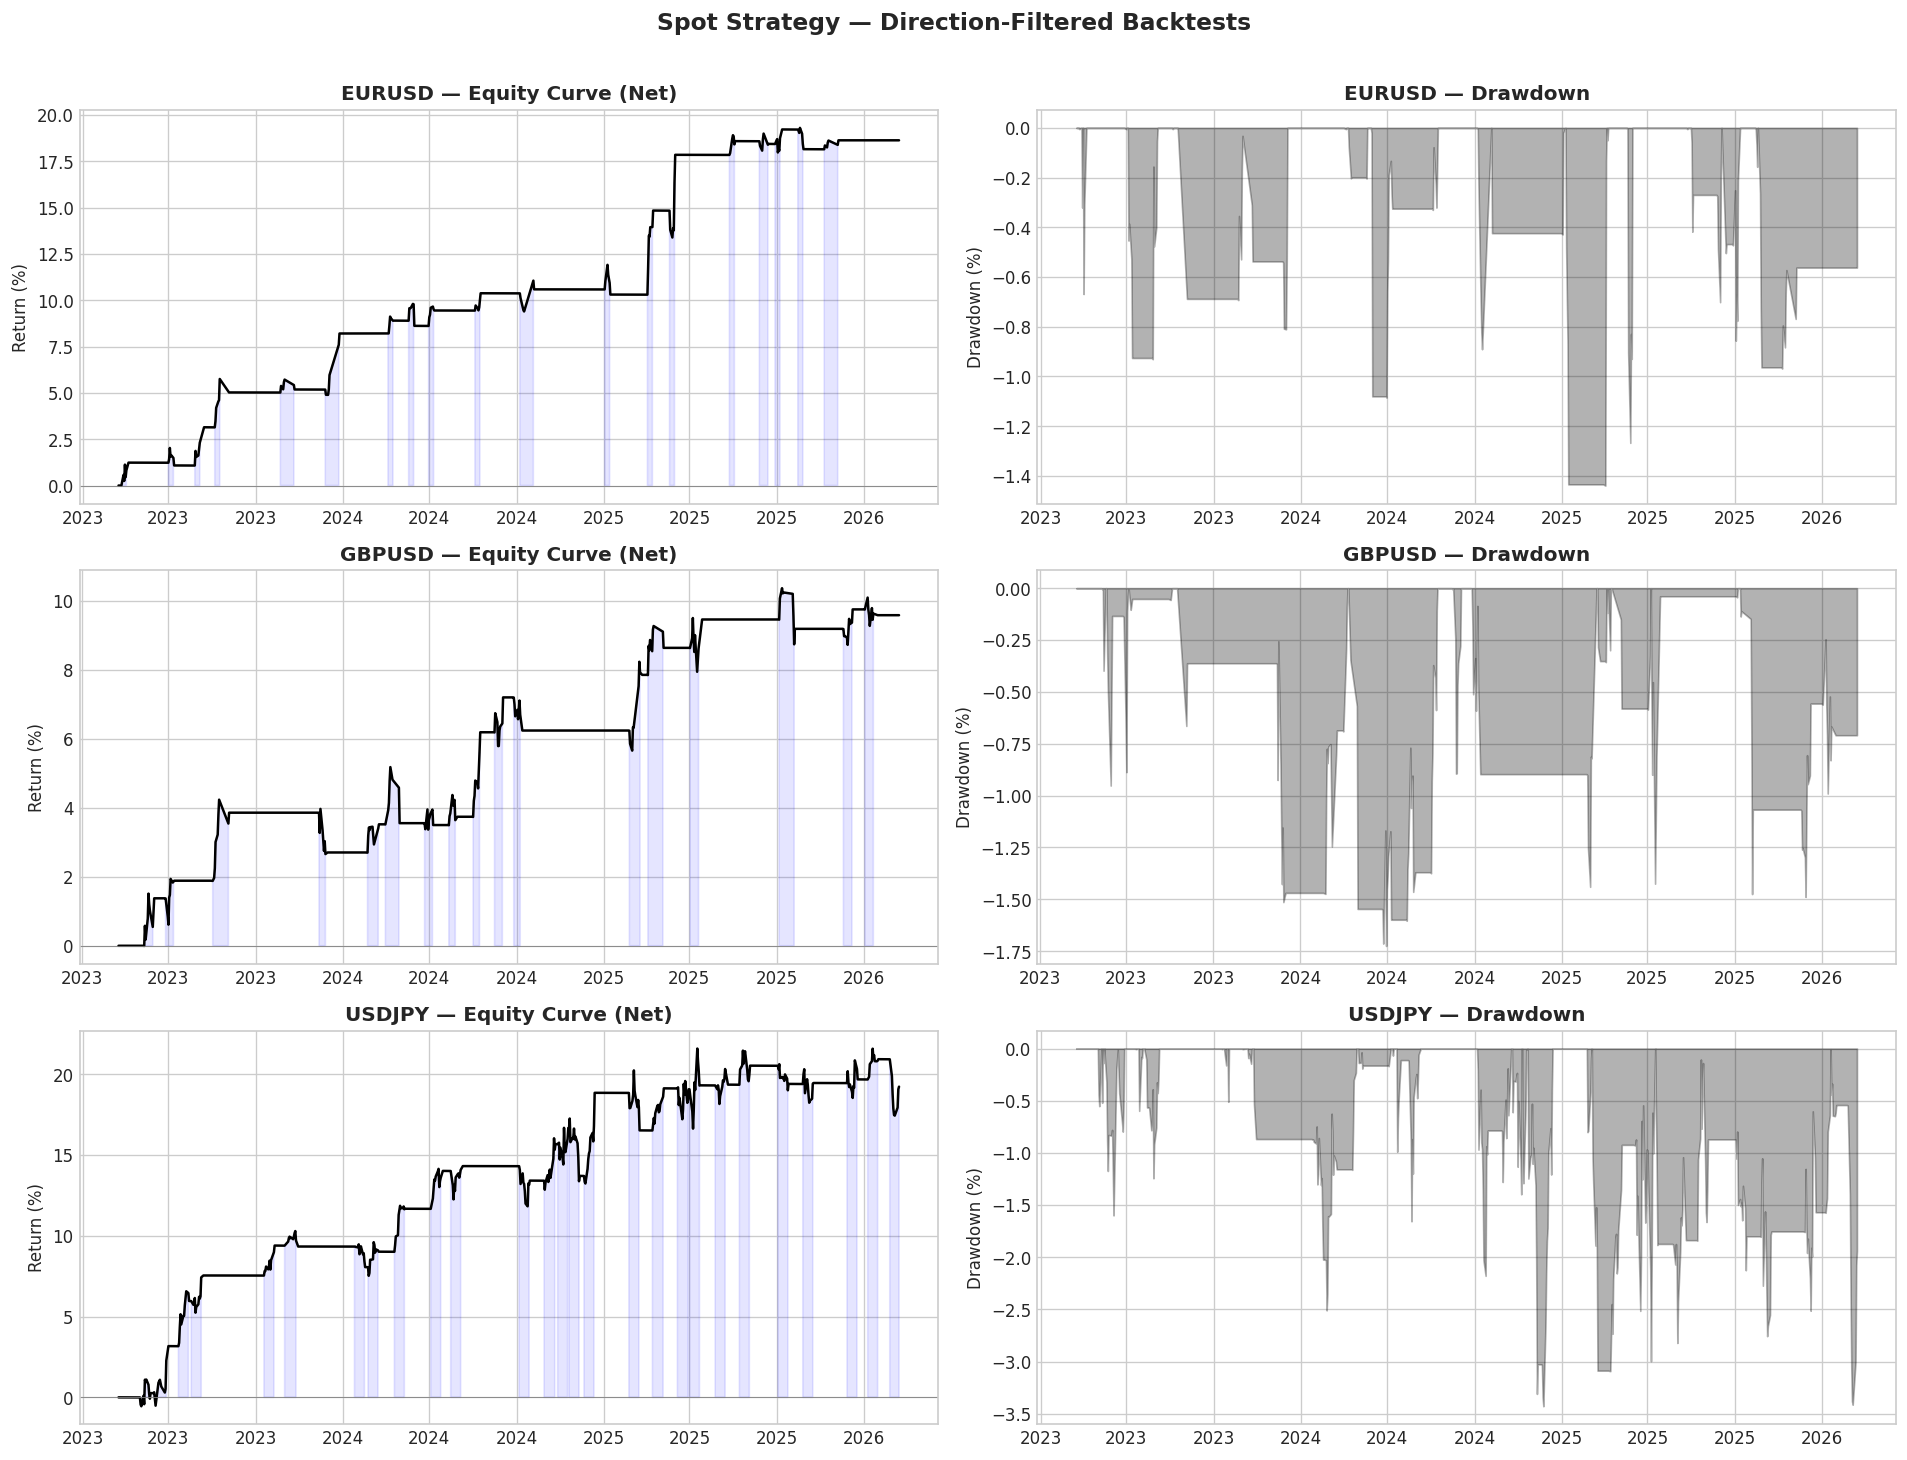

Spot Strategy KPIs


,Total Return,CAGR,Volatility,Sharpe,Sortino,Calmar,Max DD,Win Rate
Pair,,,,,,,,
EURUSD,18.6%,5.9%,3.7%,1.40,1.39,4.08,-1.4%,11.0%
GBPUSD,9.6%,3.1%,3.2%,0.63,0.54,1.80,-1.7%,13.5%
USDJPY,19.2%,6.0%,5.7%,0.71,0.76,1.76,-3.4%,22.4%


In [2]:
# Section 1: Spot Backtest KPIs + Equity Curves
# =================================================

pm = PerformanceMetrics(risk_free_rate=0.02)

kpi_rows = []
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

for i, ccy in enumerate(CURRENCIES):
    bt = backtests[ccy]
    pair = PAIR_MAP[ccy]
    bt_df = bt['bt']

    metrics = pm.calculate_all_metrics(
        bt_df['cum_net'].set_axis(pd.DatetimeIndex(bt_df['date'])),
        bt_df['net_ret'].set_axis(pd.DatetimeIndex(bt_df['date'])))
    kpi_rows.append({'Pair': pair, **{k: v for k, v in metrics.items()
                     if k in ['total_return', 'cagr', 'volatility', 'sharpe_ratio',
                              'sortino_ratio', 'calmar_ratio', 'max_drawdown', 'win_rate']}})

    ax = axes[i, 0]
    ax.plot(bt_df['date'], (bt_df['cum_net'] - 1) * 100, lw=1.5, color='black')
    ax.fill_between(bt_df['date'], 0, (bt_df['cum_net'] - 1) * 100,
                    where=bt_df['position'] != 0, alpha=0.1, color='blue')
    ax.set_title(f'{pair} — Equity Curve (Net)', fontweight='bold')
    ax.set_ylabel('Return (%)')
    ax.axhline(0, color='grey', lw=0.5)

    ax = axes[i, 1]
    dd = (bt_df['cum_net'] / bt_df['cum_net'].cummax() - 1) * 100
    ax.fill_between(bt_df['date'], dd, 0, color='black', alpha=0.3)
    ax.set_title(f'{pair} — Drawdown', fontweight='bold')
    ax.set_ylabel('Drawdown (%)')

for ax_row in axes:
    for ax in ax_row:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('Spot Strategy — Direction-Filtered Backtests',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

kpi_df = pd.DataFrame(kpi_rows).set_index('Pair')
fmt_kpi = kpi_df.copy()
for col in ['total_return', 'cagr', 'volatility', 'max_drawdown', 'win_rate']:
    fmt_kpi[col] = fmt_kpi[col].apply(lambda x: f"{x*100:.1f}%")
for col in ['sharpe_ratio', 'sortino_ratio', 'calmar_ratio']:
    fmt_kpi[col] = fmt_kpi[col].apply(lambda x: f"{x:.2f}")
fmt_kpi.columns = ['Total Return', 'CAGR', 'Volatility', 'Sharpe', 'Sortino',
                    'Calmar', 'Max DD', 'Win Rate']
print('Spot Strategy KPIs')
print('=' * 70)
display(fmt_kpi)


In [3]:
# Section 2: Option Pricing Engine + Per-Trade P&L
# ===================================================

def get_sabr_row(ccy, tenor, date):
    lookup = sabr_lookup[ccy][tenor]
    if date in lookup.index:
        return lookup.loc[date]
    for offset in [pd.Timedelta(days=d) for d in [1, -1, 2, -2]]:
        alt = date + offset
        if alt in lookup.index:
            return lookup.loc[alt]
    return None

def get_sabr_row_with_fallback(ccy, tenor, fallback, date):
    row = get_sabr_row(ccy, tenor, date)
    return row if row is not None else get_sabr_row(ccy, fallback, date)

def price_at_strike(sabr_row, K, is_call, T_override=None):
    F = sabr_row['forward']
    T = T_override if T_override is not None else sabr_row['T']
    if T <= 0:
        T = 1 / 365
    sigma = sabr_implied_vol(F, K, T, sabr_row['alpha'], sabr_row['rho'], sabr_row['nu'])
    if sigma <= 0 or np.isnan(sigma):
        return np.nan
    return black76_price(F, K, T, sigma, is_call)

def find_25delta_strikes(F, sigma, T):
    sqrt_T = np.sqrt(max(T, 1/365))
    K_call = F * np.exp(0.6745 * sigma * sqrt_T + 0.5 * sigma**2 * T)
    K_put = F * np.exp(-0.6745 * sigma * sqrt_T + 0.5 * sigma**2 * T)
    return K_call, K_put

def compute_trade_pnl(ccy, signal_date, hold_days, is_call):
    entry_date = pd.Timestamp(signal_date)
    exit_date = entry_date + pd.Timedelta(days=hold_days)

    entry_sabr = get_sabr_row(ccy, '1M', entry_date)
    exit_sabr = get_sabr_row_with_fallback(ccy, '1M', '3M', exit_date)
    if entry_sabr is None or exit_sabr is None:
        return None
    if entry_sabr['alpha'] < 0.01 or exit_sabr['alpha'] < 0.01:
        return None

    F_entry, F_exit = entry_sabr['forward'], exit_sabr['forward']
    T_entry = entry_sabr['T']
    T_remaining = max(T_entry - hold_days / 365, 1 / 365)

    # ATM option
    K_atm = F_entry
    opt_entry = price_at_strike(entry_sabr, K_atm, is_call)
    opt_exit = price_at_strike(exit_sabr, K_atm, is_call, T_override=T_remaining)
    if np.isnan(opt_entry) or np.isnan(opt_exit) or opt_entry <= 0:
        return None
    opt_net_pnl = (opt_exit - opt_entry) - COST_PCT * (opt_entry + opt_exit)

    # Risk reversal
    sigma_atm = entry_sabr['alpha']
    K_call_25d, K_put_25d = find_25delta_strikes(F_entry, sigma_atm, T_entry)
    if is_call:
        rr_long_K, rr_short_K = K_call_25d, K_put_25d
        rr_long_call, rr_short_call = True, False
    else:
        rr_long_K, rr_short_K = K_put_25d, K_call_25d
        rr_long_call, rr_short_call = False, True

    rr_le = price_at_strike(entry_sabr, rr_long_K, rr_long_call)
    rr_se = price_at_strike(entry_sabr, rr_short_K, rr_short_call)
    if np.isnan(rr_le) or np.isnan(rr_se):
        return None
    rr_lx = price_at_strike(exit_sabr, rr_long_K, rr_long_call, T_override=T_remaining)
    rr_sx = price_at_strike(exit_sabr, rr_short_K, rr_short_call, T_override=T_remaining)
    if np.isnan(rr_lx) or np.isnan(rr_sx):
        return None

    rr_entry_cost = rr_le - rr_se
    rr_exit_val = rr_lx - rr_sx
    rr_net_pnl = (rr_exit_val - rr_entry_cost) - COST_PCT * (rr_le + rr_se + rr_lx + rr_sx)

    spot_pnl = (F_exit - F_entry) if is_call else (F_entry - F_exit)

    return {
        'entry_date': entry_date, 'exit_date': exit_date,
        'F_entry': F_entry, 'F_exit': F_exit,
        'T_entry': T_entry, 'T_remaining': T_remaining,
        'spot_pnl': spot_pnl,
        'spot_pnl_bps': spot_pnl / F_entry * 10000,
        'opt_premium': opt_entry,
        'opt_net_pnl': opt_net_pnl,
        'opt_pnl_bps': opt_net_pnl / F_entry * 10000,
        'opt_return_on_premium': opt_net_pnl / opt_entry,
        'rr_entry_cost': rr_entry_cost,
        'rr_net_pnl': rr_net_pnl,
        'rr_pnl_bps': rr_net_pnl / F_entry * 10000,
    }

# Run on all signal dates
all_trades = {}
for ccy in CURRENCIES:
    config = pair_data[ccy]['config']
    is_call = (config['trade_direction'] == 'bull')
    trades = []
    for sig_date in pair_data[ccy]['signal_dates']:
        result = compute_trade_pnl(ccy, sig_date, config['hold_days'], is_call)
        if result is not None:
            result['pair'] = PAIR_MAP[ccy]
            result['currency'] = ccy
            trades.append(result)
    all_trades[ccy] = pd.DataFrame(trades)
    t = all_trades[ccy]
    n = len(t)
    skipped = len(pair_data[ccy]['signal_dates']) - n
    print(f"{PAIR_MAP[ccy]}: {n} trades ({skipped} skipped)")
    if n > 0:
        print(f"  Spot:   {t['spot_pnl_bps'].mean():+.1f} bps mean, {(t['spot_pnl_bps']>0).mean()*100:.0f}% hit")
        print(f"  Option: {t['opt_pnl_bps'].mean():+.1f} bps mean, {(t['opt_pnl_bps']>0).mean()*100:.0f}% hit")
        print(f"  RR:     {t['rr_pnl_bps'].mean():+.1f} bps mean, {(t['rr_pnl_bps']>0).mean()*100:.0f}% hit")


EURUSD: 24 trades (0 skipped)
  Spot:   +41.7 bps mean, 75% hit
  Option: +11.3 bps mean, 50% hit
  RR:     +15.4 bps mean, 67% hit
GBPUSD: 19 trades (0 skipped)
  Spot:   +41.8 bps mean, 79% hit
  Option: +9.4 bps mean, 58% hit
  RR:     +8.8 bps mean, 53% hit
USDJPY: 43 trades (0 skipped)
  Spot:   +42.4 bps mean, 58% hit
  Option: +1.1 bps mean, 40% hit
  RR:     +14.8 bps mean, 51% hit


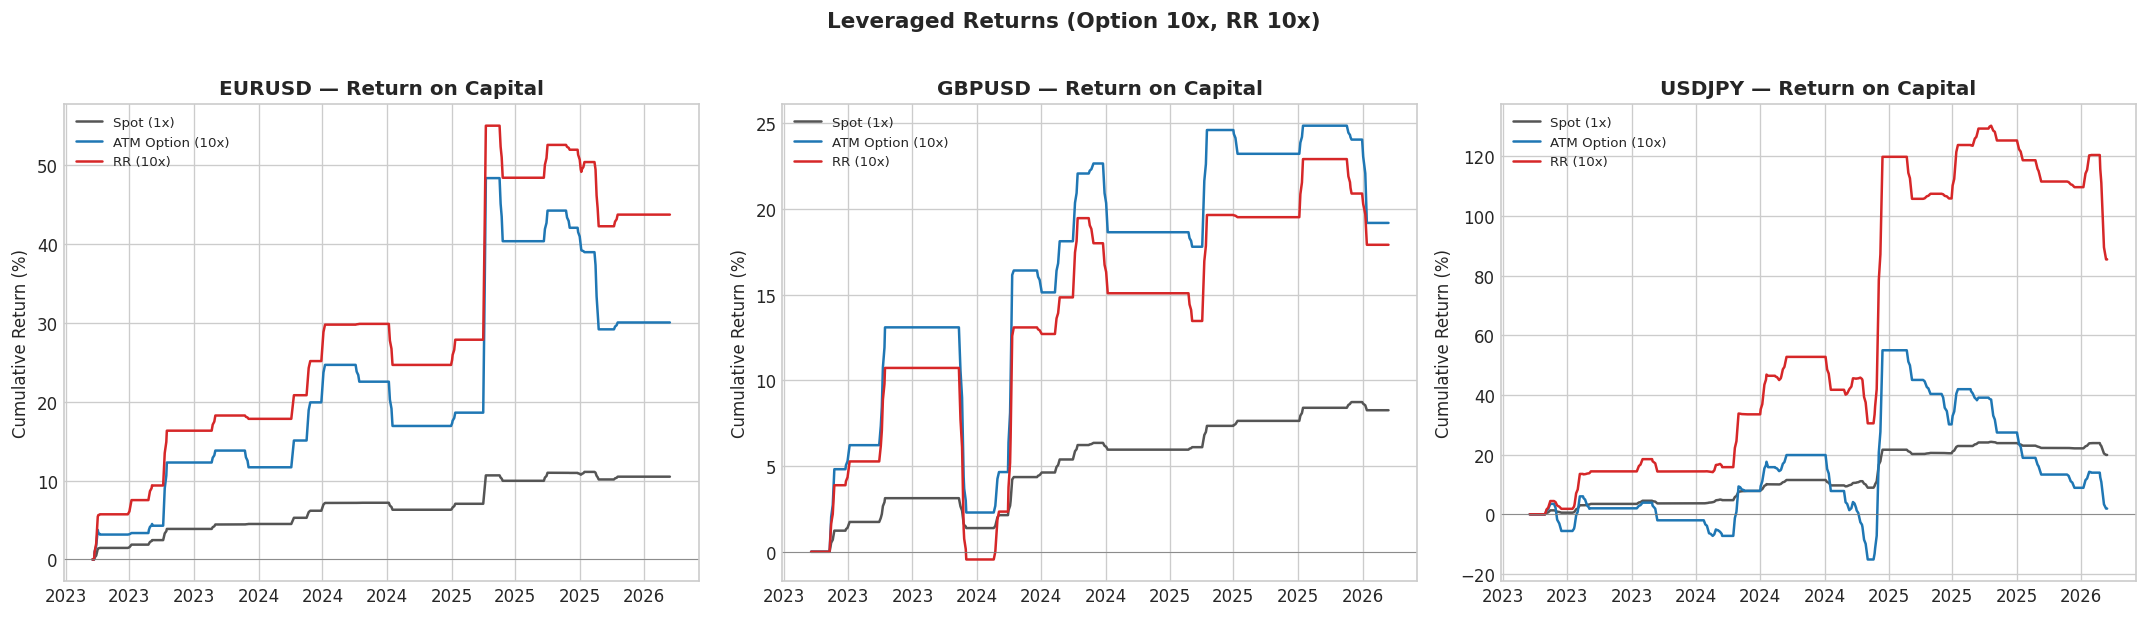

In [4]:
# Section 3: Leveraged Equity Curves (10x)
# ============================================

OPTION_LEVERAGE = 10
RR_LEVERAGE = 10

daily_series = {}
for ccy in CURRENCIES:
    trades_df = all_trades[ccy]
    config = pair_data[ccy]['config']
    hold_days = config['hold_days']
    df = pair_data[ccy]['df']
    dates = pd.DatetimeIndex(sorted(df['date'].dropna().unique()))

    spot_daily = pd.Series(0.0, index=dates)
    option_daily = pd.Series(0.0, index=dates)
    rr_daily = pd.Series(0.0, index=dates)

    for _, trade in trades_df.iterrows():
        entry = trade['entry_date']
        hold_dates = dates[(dates >= entry) & (dates < entry + pd.Timedelta(days=hold_days + 2))]
        hold_dates = hold_dates[:hold_days]
        n_hold = len(hold_dates)
        if n_hold == 0:
            continue
        spot_daily.loc[hold_dates] += (trade['spot_pnl'] / trade['F_entry']) / n_hold
        if trade['opt_premium'] > 0:
            option_daily.loc[hold_dates] += OPTION_LEVERAGE * (trade['opt_net_pnl'] / trade['F_entry']) / n_hold
        rr_daily.loc[hold_dates] += RR_LEVERAGE * (trade['rr_net_pnl'] / trade['F_entry']) / n_hold

    daily_series[ccy] = {'spot': spot_daily, 'option': option_daily, 'rr': rr_daily}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colours = {'spot': '#555555', 'option': '#1f77b4', 'rr': '#d62728'}
for i, ccy in enumerate(CURRENCIES):
    ax = axes[i]
    for label, key, c in [('Spot (1x)', 'spot', colours['spot']),
                           (f'ATM Option ({OPTION_LEVERAGE}x)', 'option', colours['option']),
                           (f'RR ({RR_LEVERAGE}x)', 'rr', colours['rr'])]:
        s = daily_series[ccy][key]
        ax.plot(s.index, ((1 + s).cumprod() - 1) * 100, color=c, lw=1.5, label=label)
    ax.axhline(0, color='grey', lw=0.5)
    ax.set_title(f'{PAIR_MAP[ccy]} — Return on Capital', fontweight='bold')
    ax.set_ylabel('Cumulative Return (%)')
    ax.legend(fontsize=8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.suptitle(f'Leveraged Returns (Option {OPTION_LEVERAGE}x, RR {RR_LEVERAGE}x)',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [5]:
# Section 4: Full KPI Table + Annual Return Breakdown
# ======================================================

pm = PerformanceMetrics(risk_free_rate=0.02)
kpi_rows = []
for ccy in CURRENCIES:
    pair = PAIR_MAP[ccy]
    for strat_label, strat_key in [('Spot', 'spot'), ('ATM Option', 'option'), ('RR', 'rr')]:
        s = daily_series[ccy][strat_key]
        cum = (1 + s).cumprod()
        metrics = pm.calculate_all_metrics(cum, s)
        kpi_rows.append({
            'Pair': pair, 'Strategy': strat_label,
            'CAGR (%)': metrics['cagr'] * 100,
            'Sharpe': metrics['sharpe_ratio'],
            'Sortino': metrics['sortino_ratio'],
            'Max DD (%)': metrics['max_drawdown'] * 100,
            'Win Rate (%)': metrics['win_rate'] * 100,
        })

kpi = pd.DataFrame(kpi_rows)
kpi_pivot = kpi.set_index(['Pair', 'Strategy']).T
fmt = kpi_pivot.copy()
for r in ['CAGR (%)', 'Max DD (%)', 'Win Rate (%)']:
    if r in fmt.index:
        fmt.loc[r] = fmt.loc[r].apply(lambda x: f"{x:.1f}")
for r in ['Sharpe', 'Sortino']:
    if r in fmt.index:
        fmt.loc[r] = fmt.loc[r].apply(lambda x: f"{x:.2f}")

print('Strategy KPIs (at 10x leverage for option/RR)')
print('=' * 70)
display(fmt)

# Annual return breakdown
print('\n\nANNUAL RETURN BREAKDOWN BY YEAR')
print('=' * 70)
annual_rows = []
for ccy in CURRENCIES:
    pair = PAIR_MAP[ccy]
    for strat_label, strat_key in [('Spot', 'spot'), ('ATM Option', 'option'), ('RR', 'rr')]:
        s = daily_series[ccy][strat_key]
        annual = s.groupby(s.index.year).apply(lambda x: (1 + x).prod() - 1) * 100
        for year, ret in annual.items():
            annual_rows.append({'Pair': pair, 'Strategy': strat_label,
                                'Year': int(year), 'Return (%)': ret})

annual_df = pd.DataFrame(annual_rows)
annual_pivot = annual_df.pivot_table(index=['Pair', 'Strategy'], columns='Year', values='Return (%)')
annual_pivot['Total'] = annual_pivot.apply(
    lambda row: ((1 + row.dropna() / 100).prod() - 1) * 100, axis=1)
annual_fmt = annual_pivot.map(lambda x: f"{x:+.1f}%" if not pd.isna(x) else "—")
display(annual_fmt)


Strategy KPIs (at 10x leverage for option/RR)


Pair         EURUSD                  GBPUSD                   USDJPY  \
Strategy       Spot ATM Option    RR   Spot ATM Option     RR   Spot   
CAGR (%)        3.4        9.2  12.9    2.7        6.0    5.7    6.2   
Sharpe         1.58       1.14  1.90   1.47       1.19   1.15   1.70   
Sortino        1.96       1.38  2.11   1.28       0.90   0.83   2.27   
Max DD (%)     -0.9      -12.9  -8.2   -1.7       -9.5  -10.1   -3.5   
Win Rate (%)   12.6        9.6  11.5   15.2       11.1    9.9   21.6   

Pair                            
Strategy     ATM Option     RR  
CAGR (%)            0.6   22.9  
Sharpe            -0.04   1.67  
Sortino           -0.08   2.16  
Max DD (%)        -34.3  -19.5  
Win Rate (%)       12.7   19.1



ANNUAL RETURN BREAKDOWN BY YEAR


Year                 2023    2024    2025    2026   Total
Pair   Strategy                                          
EURUSD ATM Option  +11.7%   +4.7%  +11.2%   +0.0%  +30.1%
       RR          +17.8%   +5.8%  +15.3%   +0.0%  +43.7%
       Spot         +4.5%   +1.7%   +3.9%   +0.0%  +10.5%
GBPUSD ATM Option   +2.3%  +16.0%   +4.6%   -3.9%  +19.2%
       RR           -0.4%  +15.6%   +5.1%   -2.5%  +17.9%
       Spot         +1.4%   +4.5%   +2.6%   -0.4%   +8.3%
USDJPY ATM Option   -2.0%  +58.2%  -29.8%   -6.4%   +1.9%
       RR          +14.4%  +92.3%   -4.6%  -11.6%  +85.5%
       Spot         +3.7%  +17.4%   +0.4%   -1.8%  +19.9%


EURUSD — Signal Quality Distribution:
  Score range: [0.264, 0.810]
  Terciles: {'weak': 8, 'medium': 8, 'strong': 8}
  Quality-Return correlation: -0.165

GBPUSD — Signal Quality Distribution:
  Score range: [0.225, 0.729]
  Terciles: {'medium': 8, 'weak': 6, 'strong': 5}
  Quality-Return correlation: -0.122

USDJPY — Signal Quality Distribution:
  Score range: [0.189, 0.830]
  Terciles: {'weak': 17, 'strong': 14, 'medium': 12}
  Quality-Return correlation: +0.330


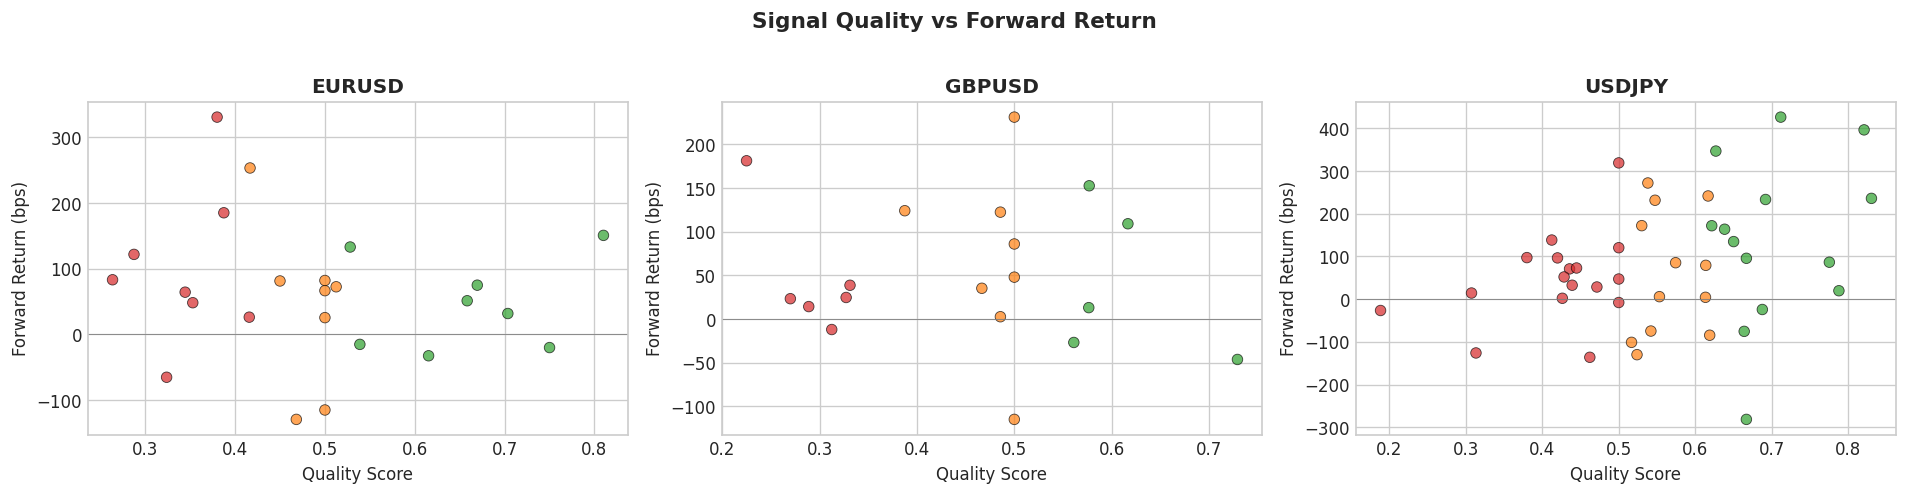

In [6]:
# Section 5: Signal Quality Ranking
# ====================================
# Score each signal at fire time using features available at that moment.
# No forward-looking bias — uses expanding-window percentile ranks.
#
# Features:
#   1. Fast rho magnitude (0.30) — bigger move = stronger conviction
#   2. Slow tenor quietness (0.20) — quieter = purer divergence
#   3. Alpha level (0.15) — higher vol = more follow-through
#   4. Rho mid-range (0.15) — more room to move
#   5. Nu level (0.20) — higher vol-of-vol = more catch-up potential

QUALITY_WEIGHTS = {
    'fast_mag': 0.30,
    'slow_quiet': 0.20,
    'alpha': 0.15,
    'rho_mid': 0.15,
    'nu': 0.20,
}

def expanding_pctile(series):
    """Expanding-window percentile rank (no lookahead)."""
    result = pd.Series(index=series.index, dtype=float)
    vals = []
    for i, (idx, val) in enumerate(series.items()):
        vals.append(val)
        if len(vals) < 5:
            result.loc[idx] = 0.5
        else:
            result.loc[idx] = sum(1 for v in vals[:-1] if v < val) / (len(vals) - 1)
    return result

def score_signals(ccy):
    """Score all signals for one currency pair."""
    df = pair_data[ccy]['df']
    config = pair_data[ccy]['config']
    signal_mask = pair_data[ccy]['signal_mask']
    fast_tenor, slow_tenor = config['fast_tenor'], config['slow_tenor']

    fast_cols = build_detection_metrics(df, fast_tenor, [config['fast_window']])
    slow_cols = build_detection_metrics(df, slow_tenor, [config['slow_window']])
    fast_col = fast_cols[(config['fast_method'], config['fast_window'])]
    slow_col = slow_cols[(config['slow_method'], config['slow_window'])]

    sig_dates = df.index[signal_mask]
    features = pd.DataFrame(index=sig_dates)
    features['fast_mag'] = df.loc[sig_dates, fast_col].abs()
    features['slow_quiet'] = df.loc[sig_dates, slow_col].abs()
    features['alpha'] = df.loc[sig_dates, f'alpha_{fast_tenor}']
    features['rho_abs'] = df.loc[sig_dates, f'rho_{fast_tenor}'].abs()
    features['nu'] = df.loc[sig_dates, f'nu_{fast_tenor}']

    scores = pd.DataFrame(index=sig_dates)
    scores['fast_mag'] = expanding_pctile(features['fast_mag'])
    scores['slow_quiet'] = 1.0 - expanding_pctile(features['slow_quiet'])
    scores['alpha'] = expanding_pctile(features['alpha'])
    scores['rho_mid'] = 1.0 - expanding_pctile(features['rho_abs'])
    scores['nu'] = expanding_pctile(features['nu'])

    scores['quality'] = sum(scores[col] * w for col, w in QUALITY_WEIGHTS.items())

    q33 = scores['quality'].quantile(0.333)
    q67 = scores['quality'].quantile(0.667)
    scores['tercile'] = pd.cut(scores['quality'], bins=[-np.inf, q33, q67, np.inf],
                                labels=['weak', 'medium', 'strong'])

    hold = config['hold_days']
    fwd_col = f'fwd_ret_{hold}d'
    if fwd_col in df.columns:
        scores['fwd_ret'] = df.loc[sig_dates, fwd_col] * SPOT_SIGN[ccy]
        if config['trade_direction'] == 'bear':
            scores['fwd_ret'] = -scores['fwd_ret']
    else:
        scores['fwd_ret'] = np.nan

    return scores, features

quality_scores = {}
for ccy in CURRENCIES:
    scores, features = score_signals(ccy)
    quality_scores[ccy] = scores
    print(f"\n{PAIR_MAP[ccy]} — Signal Quality Distribution:")
    print(f"  Score range: [{scores['quality'].min():.3f}, {scores['quality'].max():.3f}]")
    print(f"  Terciles: {scores['tercile'].value_counts().to_dict()}")

    valid = scores.dropna(subset=['quality', 'fwd_ret'])
    if len(valid) > 5:
        corr = valid['quality'].corr(valid['fwd_ret'])
        print(f"  Quality-Return correlation: {corr:+.3f}")

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, ccy in enumerate(CURRENCIES):
    ax = axes[i]
    s = quality_scores[ccy].dropna(subset=['quality', 'fwd_ret'])
    colours = s['tercile'].map({'weak': '#d62728', 'medium': '#ff7f0e', 'strong': '#2ca02c'})
    ax.scatter(s['quality'], s['fwd_ret'] * 10000, c=colours, s=40, alpha=0.7,
               edgecolors='black', lw=0.5)
    ax.axhline(0, color='grey', lw=0.5)
    ax.set_xlabel('Quality Score')
    ax.set_ylabel('Forward Return (bps)')
    ax.set_title(f'{PAIR_MAP[ccy]}', fontweight='bold')

fig.suptitle('Signal Quality vs Forward Return', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [7]:
# Section 6: Quality Validation — Does Ranking Improve Sharpe?
# ================================================================

validation_rows = []
for ccy in CURRENCIES:
    scores = quality_scores[ccy]
    df = pair_data[ccy]['df']
    config = pair_data[ccy]['config']

    for tercile_label in ['strong', 'medium', 'weak']:
        tercile_mask = scores['tercile'] == tercile_label
        tercile_idx = scores.index[tercile_mask]

        if len(tercile_idx) < 3:
            continue

        subset_mask = pd.Series(False, index=df.index)
        subset_mask.loc[tercile_idx] = True

        direction = config['trade_direction']
        if direction == 'bull':
            bt = run_backtest(df, subset_mask, pd.Series(False, index=df.index),
                              hold_days=config['hold_days'], spot_sign=SPOT_SIGN[ccy])
        else:
            bt = run_backtest(df, pd.Series(False, index=df.index), subset_mask,
                              hold_days=config['hold_days'], spot_sign=SPOT_SIGN[ccy])

        rets = scores.loc[tercile_mask, 'fwd_ret'].dropna()

        validation_rows.append({
            'Pair': PAIR_MAP[ccy],
            'Quality': tercile_label,
            'N Trades': bt['n_trades'],
            'Sharpe': bt['sharpe_net'],
            'Return (%)': bt['total_return_net'],
            'MaxDD (%)': bt['max_drawdown'],
            'Mean Ret (bps)': rets.mean() * 10000 if len(rets) > 0 else np.nan,
            'Hit Rate': (rets > 0).mean() if len(rets) > 0 else np.nan,
        })

val_df = pd.DataFrame(validation_rows)

print('Signal Quality Validation — Tercile Comparison')
print('=' * 70)
display(val_df.set_index(['Pair', 'Quality']).round(2))

print('\nMonotonicity Check (Strong > Medium > Weak):')
for ccy in CURRENCIES:
    pair = PAIR_MAP[ccy]
    pair_val = val_df[val_df['Pair'] == pair]
    strong = pair_val.loc[pair_val['Quality'] == 'strong', 'Mean Ret (bps)'].values
    medium = pair_val.loc[pair_val['Quality'] == 'medium', 'Mean Ret (bps)'].values
    weak = pair_val.loc[pair_val['Quality'] == 'weak', 'Mean Ret (bps)'].values

    if len(strong) > 0 and len(medium) > 0 and len(weak) > 0:
        mono = strong[0] > medium[0] > weak[0]
        print(f"  {pair}: Strong={strong[0]:+.1f}, Medium={medium[0]:+.1f}, "
              f"Weak={weak[0]:+.1f} → {'MONOTONIC' if mono else 'not monotonic'}")
    else:
        print(f"  {pair}: insufficient data for all terciles")


Signal Quality Validation — Tercile Comparison


N Trades  Sharpe  Return (%)  MaxDD (%)  Mean Ret (bps)  \
Pair   Quality                                                            
EURUSD strong         16    0.95        5.83      -2.68           46.81   
       medium         12    0.53        2.55      -1.95           42.18   
       weak           16    1.95       11.26      -0.96           99.34   
GBPUSD strong         10    0.27        1.01      -2.96           40.21   
       medium         16    0.54        3.12      -2.49           66.71   
       weak           12    1.30        5.09      -0.89           44.91   
USDJPY strong         20    1.28       15.54      -3.41          137.68   
       medium         21    0.79        8.26      -3.67           58.36   
       weak           26    0.88        9.94      -2.66           46.70   

                Hit Rate  
Pair   Quality            
EURUSD strong       0.62  
       medium       0.75  
       weak         0.88  
GBPUSD strong       0.60  
       medium       0.88  
       weak         0.83  
USDJPY strong       0.79  
       medium       0.67  
       weak         0.76


Monotonicity Check (Strong > Medium > Weak):
  EURUSD: Strong=+46.8, Medium=+42.2, Weak=+99.3 → not monotonic
  GBPUSD: Strong=+40.2, Medium=+66.7, Weak=+44.9 → not monotonic
  USDJPY: Strong=+137.7, Medium=+58.4, Weak=+46.7 → MONOTONIC


In [8]:
# Section 7: Position Sizing with Quality Score
# =================================================

TOTAL_BUDGET = 5000
MARGIN_PER_CONTRACT = {'EUR': 1200, 'GBP': 1000, 'JPY': 800}
SIZING_MAP = {'strong': 3, 'medium': 2, 'weak': 1}

print('Position Sizing Framework')
print('=' * 70)
print(f'Total budget: ${TOTAL_BUDGET:,}')
print(f'Contracts per signal: strong={SIZING_MAP["strong"]}, '
      f'medium={SIZING_MAP["medium"]}, weak={SIZING_MAP["weak"]}')
print(f'Margin per contract: EUR=${MARGIN_PER_CONTRACT["EUR"]}, '
      f'GBP=${MARGIN_PER_CONTRACT["GBP"]}, JPY=${MARGIN_PER_CONTRACT["JPY"]}')

sizing_rows = []
for ccy in CURRENCIES:
    scores = quality_scores[ccy]
    trades_df = all_trades[ccy]
    if len(trades_df) == 0:
        continue

    for idx, score_row in scores.iterrows():
        tercile = score_row['tercile']
        if pd.isna(tercile):
            continue
        contracts = SIZING_MAP.get(tercile, 1)
        margin = contracts * MARGIN_PER_CONTRACT[ccy]

        entry_date = pair_data[ccy]['df'].loc[idx, 'date']
        match = trades_df[trades_df['entry_date'] == entry_date]
        if len(match) == 0:
            continue

        trade = match.iloc[0]
        sizing_rows.append({
            'Pair': PAIR_MAP[ccy],
            'Date': entry_date,
            'Quality': score_row['quality'],
            'Tercile': tercile,
            'Contracts': contracts,
            'Margin ($)': margin,
            'RR P&L/contract (bps)': trade['rr_pnl_bps'],
            'Weighted P&L (bps)': trade['rr_pnl_bps'] * contracts,
        })

sizing_df = pd.DataFrame(sizing_rows)

print('\nQuality-Weighted vs Equal-Weight (2 contracts each) Comparison:')
print('-' * 60)
for ccy in CURRENCIES:
    pair = PAIR_MAP[ccy]
    pair_sizing = sizing_df[sizing_df['Pair'] == pair]
    if len(pair_sizing) == 0:
        continue

    weighted_total = pair_sizing['Weighted P&L (bps)'].sum()
    equal_total = pair_sizing['RR P&L/contract (bps)'].sum() * 2
    weighted_avg_contracts = pair_sizing['Contracts'].mean()

    print(f"  {pair}: Quality-weighted={weighted_total:+.0f} bps "
          f"({weighted_avg_contracts:.1f} avg contracts), "
          f"Equal-weight(2x)={equal_total:+.0f} bps")
    improvement = (weighted_total - equal_total) / abs(equal_total) * 100 if equal_total != 0 else 0
    print(f"          Improvement: {improvement:+.1f}%")


Position Sizing Framework
Total budget: $5,000
Contracts per signal: strong=3, medium=2, weak=1
Margin per contract: EUR=$1200, GBP=$1000, JPY=$800

Quality-Weighted vs Equal-Weight (2 contracts each) Comparison:
------------------------------------------------------------
  EURUSD: Quality-weighted=+437 bps (2.0 avg contracts), Equal-weight(2x)=+737 bps
          Improvement: -40.7%
  GBPUSD: Quality-weighted=+308 bps (1.9 avg contracts), Equal-weight(2x)=+334 bps
          Improvement: -7.7%
  USDJPY: Quality-weighted=+1808 bps (1.9 avg contracts), Equal-weight(2x)=+1274 bps
          Improvement: +41.9%


Combined Portfolio (Equal-Weight 3 Pairs) — Return on Capital
  Spot           : CAGR   4.1% | Sharpe 1.98 | MaxDD -1.2%
  ATM Option     : CAGR   5.5% | Sharpe 0.61 | MaxDD -15.8%
  Risk Reversal  : CAGR  13.8% | Sharpe 2.28 | MaxDD -9.2%

Combined Portfolio — Annual Returns:


Year,2023,2024,2025,2026,Total
Strategy,,,,,
ATM Option,+3.9%,+24.9%,-6.4%,-3.5%,+17.4%
Risk Reversal,+10.3%,+33.5%,+5.0%,-4.8%,+47.3%
Spot,+3.2%,+7.7%,+2.3%,-0.7%,+12.8%


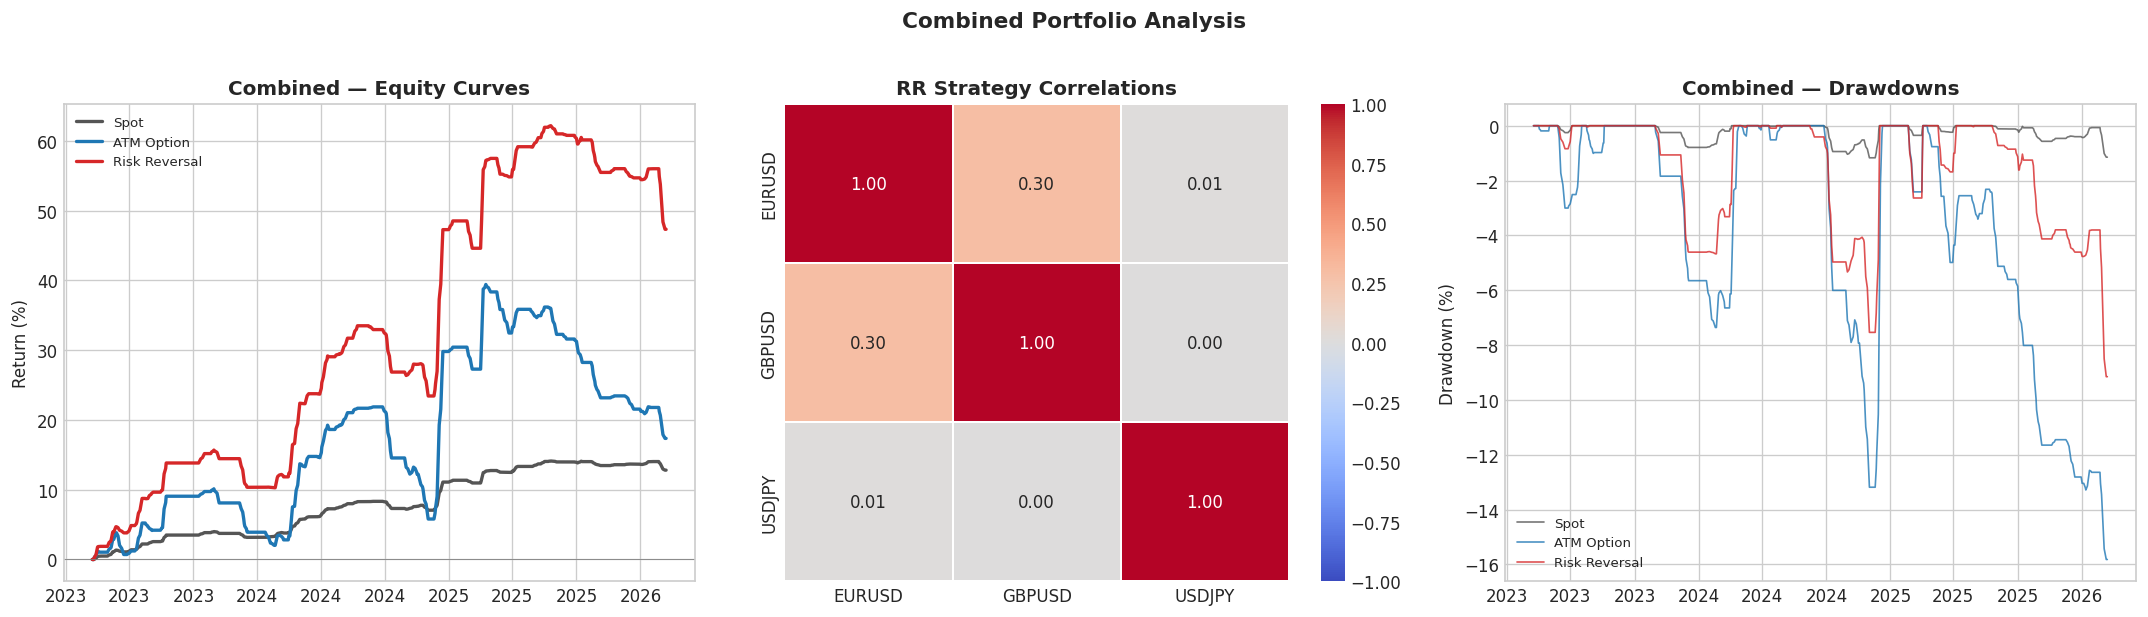

In [9]:
# Section 8: Combined Portfolio
# ================================

combined_data = {}
strat_labels = {'spot': 'Spot', 'option': 'ATM Option', 'rr': 'Risk Reversal'}
for strat_key in ['spot', 'option', 'rr']:
    strat_rets = {PAIR_MAP[c]: daily_series[c][strat_key] for c in CURRENCIES}
    strat_df = pd.DataFrame(strat_rets).fillna(0)
    strat_df['Combined'] = strat_df.mean(axis=1)
    strat_df['cum'] = (1 + strat_df['Combined']).cumprod()
    combined_data[strat_key] = strat_df

pm = PerformanceMetrics(risk_free_rate=0.02)

print('Combined Portfolio (Equal-Weight 3 Pairs) — Return on Capital')
print('=' * 70)
for strat_key, label in strat_labels.items():
    cdf = combined_data[strat_key]
    m = pm.calculate_all_metrics(cdf['cum'], cdf['Combined'])
    print(f"  {label:15s}: CAGR {m['cagr']*100:5.1f}% | Sharpe {m['sharpe_ratio']:.2f} | "
          f"MaxDD {m['max_drawdown']*100:.1f}%")

# Annual breakdown
print('\nCombined Portfolio — Annual Returns:')
annual_combined = []
for strat_key, label in strat_labels.items():
    s = combined_data[strat_key]['Combined']
    annual = s.groupby(s.index.year).apply(lambda x: (1 + x).prod() - 1) * 100
    for year, ret in annual.items():
        annual_combined.append({'Strategy': label, 'Year': int(year), 'Return (%)': ret})
annual_comb_pivot = pd.DataFrame(annual_combined).pivot_table(
    index='Strategy', columns='Year', values='Return (%)')
annual_comb_pivot['Total'] = annual_comb_pivot.apply(
    lambda row: ((1 + row.dropna() / 100).prod() - 1) * 100, axis=1)
display(annual_comb_pivot.map(lambda x: f"{x:+.1f}%" if not pd.isna(x) else "—"))

# Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
strat_colours = {'spot': '#555555', 'option': '#1f77b4', 'rr': '#d62728'}

ax = axes[0]
for strat_key, label in strat_labels.items():
    cum = combined_data[strat_key]['cum']
    ax.plot(cum.index, (cum - 1) * 100, color=strat_colours[strat_key], lw=2, label=label)
ax.set_title('Combined — Equity Curves', fontweight='bold')
ax.set_ylabel('Return (%)')
ax.legend(fontsize=8)
ax.axhline(0, color='grey', lw=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax = axes[1]
rr_df = combined_data['rr']
pair_cols = [PAIR_MAP[c] for c in CURRENCIES]
corr = rr_df[pair_cols].corr()
sns.heatmap(corr, ax=ax, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, linewidths=1)
ax.set_title('RR Strategy Correlations', fontweight='bold')

ax = axes[2]
for strat_key, label in strat_labels.items():
    cum = combined_data[strat_key]['cum']
    dd = (cum / cum.cummax() - 1) * 100
    ax.plot(dd.index, dd, color=strat_colours[strat_key], lw=1, label=label, alpha=0.8)
ax.set_title('Combined — Drawdowns', fontweight='bold')
ax.set_ylabel('Drawdown (%)')
ax.legend(fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('Combined Portfolio Analysis', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
